# Using Florence2 as Remotely Sourced Zoo Model

In [1]:
import fiftyone as fo

# Load a dataset
dataset = fo.load_dataset("cardd_from_hub")
dataset = dataset.take(5)

In [2]:
dataset

Dataset:     cardd_from_hub
Media type:  image
Num samples: 5
Sample fields:
    id:                        fiftyone.core.fields.ObjectIdField
    filepath:                  fiftyone.core.fields.StringField
    tags:                      fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:                  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:                fiftyone.core.fields.DateTimeField
    last_modified_at:          fiftyone.core.fields.DateTimeField
    ground_truth:              fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    yolo11_small:              fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    yolo11_large:              fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    thumbnails_path:           fiftyone.core.fields.StringField
    polylines:                 fiftyone.core.fields.EmbeddedDocument

For context, here is the first image:

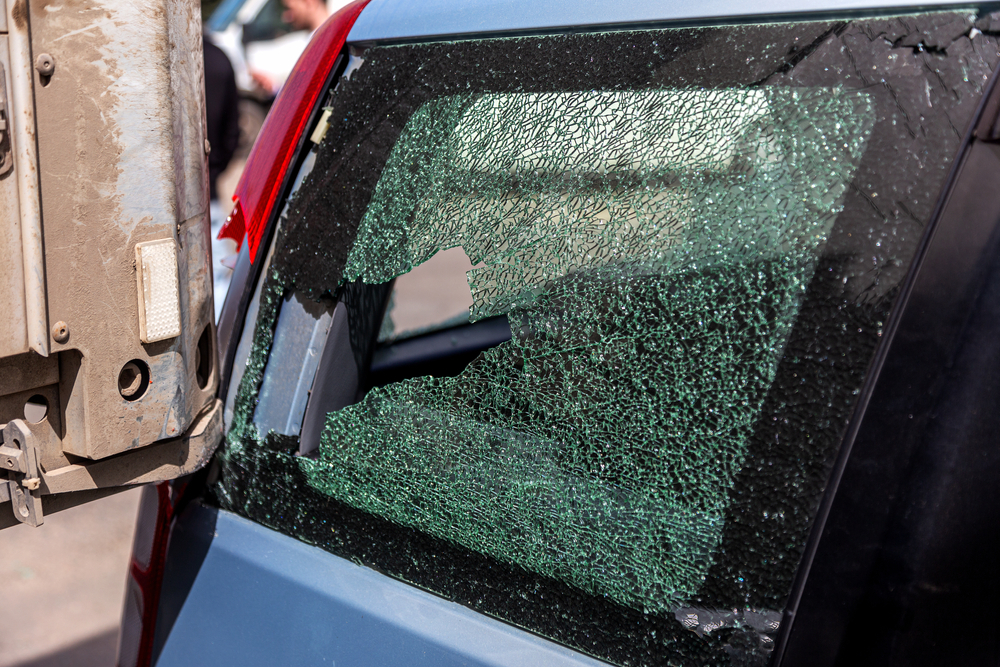

In [3]:
from PIL import Image

Image.open(dataset.first().filepath)

# Setup Zoo Model

In [4]:
import fiftyone.zoo as foz 
foz.register_zoo_model_source("https://github.com/harpreetsahota204/florence2", overwrite=True)

    5.3Mb [358.6ms elapsed, ? remaining, 14.9Mb/s] 
Overwriting existing model source '/Users/harpreetsahota/fiftyone/__models__/Florence2'


In [5]:
foz.download_zoo_model(
    "https://github.com/harpreetsahota204/florence2",
    model_name="microsoft/Florence-2-base-ft", 
)

/opt/anaconda3/envs/fiftyone/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 15 files: 100%|██████████| 15/15 [00:00<00:00, 29.57it/s]


(<fiftyone.zoo.models.RemoteZooModel at 0x14ba2ec10>,
 '/Users/harpreetsahota/fiftyone/__models__/Florence2/Florence-2-base-ft')

In [6]:
model = foz.load_zoo_model(
    "microsoft/Florence-2-base-ft"
    )

Fetching 15 files: 100%|██████████| 15/15 [00:00<00:00, 4236.10it/s]
/opt/anaconda3/envs/fiftyone/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model c

# Use Florence2 for Captions

The three captioning operations require no additional arguments beyond selecting the operation type. 

Supported `detail_level` values:

* `basic`

*  `detailed`

* `more_detailed`

In [7]:
model.operation="caption"
model.detail_level= "basic"

In [8]:
dataset.apply_model(model, label_field="captions")

 100% |█████████████████████| 5/5 [2.0s elapsed, 0s remaining, 2.5 samples/s]      


In [9]:
dataset.first()['captions']

'A broken window of a car with a broken glass.'

To change the caption detail level:

In [10]:
model.detail_level= "more_detailed"

dataset.apply_model(model, label_field="more_detailed_captions")

dataset.first()['more_detailed_captions']

 100% |█████████████████████| 5/5 [4.9s elapsed, 0s remaining, 1.0 samples/s]   


"The window of a car is cracked. The windshield is green. The car is blue. The sun is shining on the windshield. There is a metal structure to the left of the window. The metal structure is gray. There are people standing behind the car. The person is wearing a white shirt. The people are wearing dark clothing. There's a person standing behind a white car."

# Use Florence2 for Detection

The operations for `detection`, `dense_region_caption`, `region_proposal` don't require additional parameters for general use. 

However, `open_vocabulary_detection` requires a `text_prompt` parameter to guide the detection towards specific objects. 


The results are stored as Detections objects containing bounding boxes and labels:

In [11]:
model.operation="detection"

model.detection_type="open_vocabulary_detection"

model.prompt="crack, windshield"

dataset.apply_model(model, label_field="ov_prompted_detection")

 100% |█████████████████████| 5/5 [1.4s elapsed, 0s remaining, 3.5 samples/s]         


In [12]:
dataset.first()['ov_prompted_detection']

<Detections: {
    'detections': [
        <Detection: {
            'id': '67f55ececd0813ab39bf0304',
            'attributes': {},
            'tags': [],
            'label': 'crack, windshield',
            'bounding_box': [0.2075, 0.0004999999967829577, 0.791, 0.9980000175725574],
            'mask': None,
            'mask_path': None,
            'confidence': None,
            'index': None,
        }>,
    ],
}>

Or you can use the caption field:

In [13]:
dataset.apply_model(model, label_field="ov_field_detection", prompt_field="captions")

 100% |█████████████████████| 5/5 [2.1s elapsed, 0s remaining, 2.4 samples/s]      


In [14]:
dataset.first()['ov_field_detection']

<Detections: {
    'detections': [
        <Detection: {
            'id': '67f55ed3cd0813ab39bf0309',
            'attributes': {},
            'tags': [],
            'label': 'A broken window of a car with a broken glass.',
            'bounding_box': [0.1135, 0.0004999999967829577, 0.885, 0.9980000175725574],
            'mask': None,
            'mask_path': None,
            'confidence': None,
            'index': None,
        }>,
    ],
}>

For dense detections. This doesn't take a prompt as the model will detect all it can:

In [15]:
model.operation="detection"

model.detection_type="dense_region_caption"

dataset.apply_model(model, label_field="dense_detections")

 100% |█████████████████████| 5/5 [1.4s elapsed, 0s remaining, 3.5 samples/s]         


In [16]:
dataset.first()['dense_detections']

<Detections: {
    'detections': [
        <Detection: {
            'id': '67f55edccd0813ab39bf030e',
            'attributes': {},
            'tags': [],
            'label': 'car',
            'bounding_box': [0.1155, 0.0004999999967829577, 0.883, 0.9980000175725574],
            'mask': None,
            'mask_path': None,
            'confidence': None,
            'index': None,
        }>,
    ],
}>

# Use Florence2 for Phrase Grounding

Phrase grounding requires either a direct caption or a reference to a caption field. You can provide this in two ways:

In [17]:
model.operation="phrase_grounding"

model.prompt="cake"

dataset.apply_model(model, label_field="cap_phrase_groundings")

 100% |█████████████████████| 5/5 [1.3s elapsed, 0s remaining, 4.0 samples/s]         


In [18]:
dataset.first()['cap_phrase_groundings']

<Detections: {
    'detections': [
        <Detection: {
            'id': '67f55edfcd0813ab39bf0315',
            'attributes': {},
            'tags': [],
            'label': 'cake',
            'bounding_box': [0.1135, 0.0004999999967829577, 0.885, 0.9980000175725574],
            'mask': None,
            'mask_path': None,
            'confidence': None,
            'index': None,
        }>,
    ],
}>

When you want to use a Field of a Sample for grounding, you use the following pattern:

In [19]:
dataset.apply_model(model, 
                    label_field="cap_field_phrase_groundings", 
                    prompt_field="more_detailed_captions"
                    )

 100% |█████████████████████| 5/5 [3.8s elapsed, 0s remaining, 1.3 samples/s]      


In [20]:
dataset.first()['cap_field_phrase_groundings']

<Detections: {
    'detections': [
        <Detection: {
            'id': '67f55ee4cd0813ab39bf031a',
            'attributes': {},
            'tags': [],
            'label': 'The window',
            'bounding_box': [0.2955, 0.11849999606519983, 0.583, 0.8080000412696484],
            'mask': None,
            'mask_path': None,
            'confidence': None,
            'index': None,
        }>,
        <Detection: {
            'id': '67f55ee4cd0813ab39bf031b',
            'attributes': {},
            'tags': [],
            'label': 'The windshield',
            'bounding_box': [0.2955, 0.11849999606519983, 0.581, 0.8080000412696484],
            'mask': None,
            'mask_path': None,
            'confidence': None,
            'index': None,
        }>,
        <Detection: {
            'id': '67f55ee4cd0813ab39bf031c',
            'attributes': {},
            'tags': [],
            'label': 'The car',
            'bounding_box': [0.1135, 0.0004999999967829577, 0.885

# Use Florence2 for Segmentation

Segmentation requires either a direct expression or a reference to a field containing expressions. 

Similar to phrase grounding, you can provide this in two ways:

In [21]:
model.operation="segmentation"

model.prompt="crack"

dataset.apply_model(model, label_field="prompted_segmentations")

 100% |█████████████████████| 5/5 [4.9s elapsed, 0s remaining, 1.0 samples/s]    


In [22]:
dataset.first()['prompted_segmentations']

<Polylines: {
    'polylines': [
        <Polyline: {
            'id': '67f55f09cd0813ab39bf0339',
            'attributes': {},
            'tags': [],
            'label': 'object_1',
            'points': [
                [
                    [0.0005, 0.0004999999967829577],
                    [0.2025, 0.0004999999967829577],
                    [0.2075, 0.0004999999967829577],
                    [0.2075, 0.05249999702602312],
                    [0.2075, 0.0765000018758931],
                    [0.2075, 0.09950000128109773],
                    [0.2075, 0.12349999469259511],
                    [0.2075, 0.14649999981698603],
                    [0.2075, 0.16549999460108814],
                    [0.2075, 0.18650000027452093],
                    [0.2075, 0.20549999505862304],
                    [0.2075, 0.22149999066628795],
                    [0.2075, 0.23550000969973997],
                    [0.2075, 0.24950000585644677],
                    [0.2075, 0.2635000020131536],
  

When you want to use a Field of a Sample for grounding, you use the following pattern:

In [23]:
dataset.apply_model(model, label_field="sample_field_segmentations", prompt_field="captions")

 100% |█████████████████████| 5/5 [13.9s elapsed, 0s remaining, 0.4 samples/s]   


In [24]:
dataset.first()['sample_field_segmentations']

<Polylines: {
    'polylines': [
        <Polyline: {
            'id': '67f55f1dcd0813ab39bf033e',
            'attributes': {},
            'tags': [],
            'label': 'object_1',
            'points': [
                [
                    [0.3495, 0.0004999999967829577],
                    [0.9995, 0.0004999999967829577],
                    [0.9995, 0.9995000058564468],
                    [0.1175, 0.9995000058564468],
                    [0.1175, 0.9975000292822339],
                    [0.1175, 0.9835000102487819],
                    [0.1175, 0.9714999677895427],
                    [0.1175, 0.9595000168372845],
                    [0.1175, 0.9505000307463456],
                    [0.1175, 0.9384999882871065],
                    [0.1175, 0.9295000021961676],
                    [0.1175, 0.9195000278181222],
                    [0.1175, 0.9104999502202024],
                    [0.1175, 0.8984999992679441],
                    [0.1175, 0.8895000131770052],
               

# OCR

Basic OCR ("ocr") requires no additional parameters and returns text strings. For OCR with region information (`ocr_with_region`), you can set `store_region_info=True` to include bounding boxes for each text region:

In [ ]:
model.operation="ocr"

model.store_region_info=True

dataset.apply_model(model, label_field="text_regions")

In [ ]:
dataset.first()['text_regions']

In [ ]:
model.store_region_info=False

dataset.apply_model(model, label_field="text_regions_no_region_info")

In [ ]:
dataset.first()['text_regions_no_region_info']